In [14]:
import os

dataset_1_path = '../Dataset-1'
files = os.listdir(dataset_1_path)
print("Arquivos no diretório Dataset-1:")
print(files)

Arquivos no diretório Dataset-1:
['Calendar.csv', 'Custumers.csv', 'Product.csv', 'Sales.csv', 'Territory.csv']


In [15]:
import pandas as pd

calendar = pd.read_csv('../Dataset-1/Calendar.csv')
customers = pd.read_csv('../Dataset-1/Custumers.csv')
product = pd.read_csv('../Dataset-1/Product.csv')
sales = pd.read_csv('../Dataset-1/Sales.csv')
territory = pd.read_csv('../Dataset-1/Territory.csv')

print("Calendar:")
print(calendar.head())
print("\nCustomers:")
print(customers.head())
print("\nProduct:")
print(product.head())
print("\nSales:")
print(sales.head())
print("\nTerritory:")
print(territory.head())


Calendar:
          Date   DateKey  Year Quarter  MonthNum Month FiscalYear  \
0  4/3/16 0:00  20160403  2016      Q2         4   Apr     FY2016   
1  4/4/16 0:00  20160404  2016      Q2         4   Apr     FY2016   
2  4/5/16 0:00  20160405  2016      Q2         4   Apr     FY2016   
3  4/6/16 0:00  20160406  2016      Q2         4   Apr     FY2016   
4  4/7/16 0:00  20160407  2016      Q2         4   Apr     FY2016   

  FiscalQuarter  FiscalMonthNum FiscalMonth MonthYear MonthYearLong  \
0           FQ4              10         Apr    Apr-16      Apr-2016   
1           FQ4              10         Apr    Apr-16      Apr-2016   
2           FQ4              10         Apr    Apr-16      Apr-2016   
3           FQ4              10         Apr    Apr-16      Apr-2016   
4           FQ4              10         Apr    Apr-16      Apr-2016   

   MonthYearNum  WeekdayNum Weekday WeekdayWeekend  
0        201604           1     Sun        Weekend  
1        201604           2     Mon       

C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_28632\846509022.py:6: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  sales = pd.read_csv('../Dataset-1/Sales.csv')


# Questão 1: Explicação das Tabelas e Relações
### Tabela Calendar
A tabela *Calendar* contém informações de datas, incluindo chave de data (DateKey), ano, trimestre, mês, e detalhes fiscais. A tabela não calendário não se relaciona diretamente com as outras tabelas, mas pode ser usada para criar relações indiretas com base em datas.

### Tabela Customers
A tabela *Customers* contém informações sobre os clientes, incluindo chave do cliente (CustomerKey), nome, data de nascimento, estado civil, gênero, renda anual, entre outros detalhes demográficos, que podem ser usados para segmentar os clientes e analisar o comportamento de compra.

### Tabela Product
A tabela Product fornece detalhes dos produtos, como chave do produto (ProductKey), nome do produto, subcategoria, categoria, custo padrão, cor, preço de lista, entre outros.

### Tabela Sales
A tabela Sales registra as vendas realizadas, incluindo chave do produto (ProductKey), data do pedido (OrderDate), data de envio (ShipDate), chave do cliente (CustomerKey), chave da promoção (PromotionKey), quantidade do pedido (OrderQuantity), preço unitário (UnitPrice), e várias colunas adicionais que parecem estar desordenadas ou desnecessárias.

### Tabela Territory
A tabela Territory contém informações sobre as regiões de vendas, incluindo chave do território de vendas (SalesTerritoryKey), região, país, grupo, e uma imagem da região (RegionImage).

## Relações entre as Tabelas
A tabela Sales está relacionada à Product através de ProductKey: N:1 (muitas vendas para um produto).
A tabela Sales está relacionada à Customers através de CustomerKey: N:1 (muitas vendas para um cliente).
A tabela Customers está relacionada à Territory através de SalesTerritoryKey: N:1 (muitos clientes para um território).


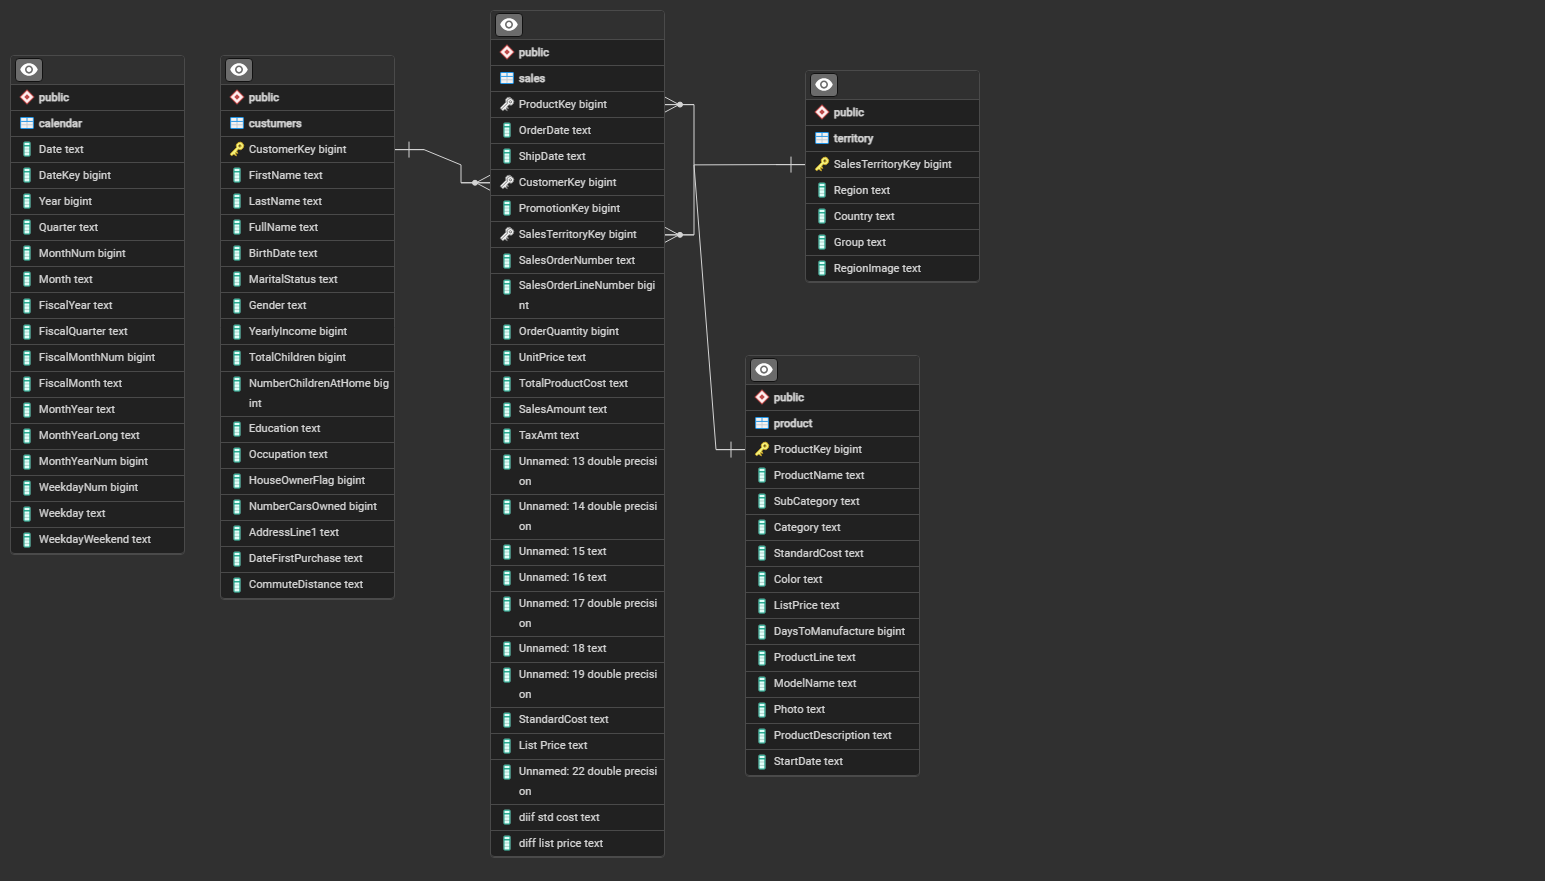

In [16]:
from IPython.display import Image, display

image_path = "../Entity-Relationship Diagram/ERD-for-schema-dataset-1.pgerd.png"
display(Image(filename=image_path))


Precisei tratar os dados antes de carregar no banco de dados:
- colunas em branco
- colunas com o tipo de dado object (comentei o código que remove) e removi apenas as colunas que não seriam utilizadas

In [29]:
import pandas as pd
import sqlite3

calendar = pd.read_csv('../Dataset-1/Calendar.csv')
customers = pd.read_csv('../Dataset-1/Custumers.csv')
product = pd.read_csv('../Dataset-1/Product.csv')
sales = pd.read_csv('../Dataset-1/Sales.csv')
territory = pd.read_csv('../Dataset-1/Territory.csv')

# FIXME: Tratativa de valores inválidos ou inconsistentes
sales.dropna(axis=1, how='all', inplace=True)
#sales = sales.select_dtypes(exclude=['object'])
# Remova as coluas 'List Price', 'StandardCost', 'diif std cost', 'diff list price'
sales = sales.drop(columns=['List Price', 'StandardCost', 'diif std cost', 'diff list price'])

conn = sqlite3.connect('db.sqlite3')
calendar.to_sql('Calendar', conn, if_exists='replace', index=False)
customers.to_sql('Custumers', conn, if_exists='replace', index=False)
product.to_sql('Product', conn, if_exists='replace', index=False)
sales.to_sql('Sales', conn, if_exists='replace', index=False)
territory.to_sql('Territory', conn, if_exists='replace', index=False)
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tabelas no banco de dados:")
print(tables)

schema = pd.read_sql_query("PRAGMA table_info(Sales);", conn)
print("\nEsquema da tabela Sales:")
print(schema)

sales_check = pd.read_sql_query("SELECT * FROM Sales LIMIT 5;", conn)
print("\nPrimeiras linhas da tabela Sales:")
print(sales_check)

invalid_values_check = sales.isnull().sum()
print("\nValores inválidos ou inconsistentes na tabela Sales:")
print(invalid_values_check)

print("\nTipos de dados das colunas na tabela Sales:")
print(sales.dtypes)

sales_check = pd.read_sql_query("SELECT * FROM Sales LIMIT 5;", conn)
print("\nPrimeiras linhas da tabela Sales:")
print(sales_check)
conn.close()


C:\Users\Erick Bryan\AppData\Local\Temp\ipykernel_28632\3396493837.py:7: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  sales = pd.read_csv('../Dataset-1/Sales.csv')


Tabelas no banco de dados:
        name
0   Calendar
1  Custumers
2    Product
3      Sales
4  Territory

Esquema da tabela Sales:
    cid                  name     type  notnull dflt_value  pk
0     0            ProductKey  INTEGER        0       None   0
1     1             OrderDate     TEXT        0       None   0
2     2              ShipDate     TEXT        0       None   0
3     3           CustomerKey  INTEGER        0       None   0
4     4          PromotionKey  INTEGER        0       None   0
5     5     SalesTerritoryKey  INTEGER        0       None   0
6     6      SalesOrderNumber     TEXT        0       None   0
7     7  SalesOrderLineNumber  INTEGER        0       None   0
8     8         OrderQuantity  INTEGER        0       None   0
9     9             UnitPrice     TEXT        0       None   0
10   10      TotalProductCost     TEXT        0       None   0
11   11           SalesAmount     TEXT        0       None   0
12   12                TaxAmt     TEXT        0   

# Questão 2: Três Produtos Mais Vendidos em Termos de Quantidade

Para encontrar os três produtos mais vendidos em termos de quantidade, podemos agrupar os dados da tabela Sales por ProductKey e somar a quantidade de pedidos (OrderQuantity) para cada produto. Em seguida, podemos classificar os produtos com base na quantidade total de pedidos em ordem decrescente e selecionar os três primeiros produtos.
Segue o código para encontrar os três produtos mais vendidos em termos de quantidade:

No SQLite:
```sql
SELECT 
Sales.ProductKey AS ProductKey,
Product.ProductName AS Product,
SUM(OrderQuantity) AS TotalQuantity
FROM Sales
INNER JOIN Product ON Product.ProductKey = Sales.ProductKey
GROUP BY Sales.ProductKey, Product.ProductName 
ORDER BY TotalQuantity DESC
LIMIT 3;
```

No PostgreSQL:
```sql
SELECT
Sales."ProductKey" AS ProductKey,
Product."ProductName" AS Product,
SUM("OrderQuantity") AS TotalQuantity
FROM Sales
INNER JOIN Product ON Product."ProductKey" = Sales."ProductKey"
GROUP BY Sales."ProductKey", Product."ProductName"
ORDER BY TotalQuantity DESC
LIMIT 3;
```

In [30]:
conn = sqlite3.connect('db.sqlite3')

query = """
SELECT Sales.ProductKey AS ProductKey, Product.ProductName AS Product, SUM(OrderQuantity) AS TotalQuantity
FROM Sales
INNER JOIN Product ON Product.ProductKey = Sales.ProductKey
GROUP BY Sales.ProductKey, Product.ProductName 
ORDER BY TotalQuantity DESC
LIMIT 3;
"""

top_products = pd.read_sql_query(query, conn)
print("Três produtos mais vendidos em termos de quantidade:")
print(top_products)
conn.close()

Três produtos mais vendidos em termos de quantidade:
   ProductKey                Product  TotalQuantity
0         477  Water Bottle - 30 oz.           6370
1         480    Patch Kit/8 Patches           4705
2         528     Mountain Tire Tube           4551
